## Keras implementation of https://phillipi.github.io/pix2pix

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # can choose theano, tensorflow, cntk
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile,dnn.library_path=/usr/lib'

In [2]:
import keras.backend as K
if os.environ['KERAS_BACKEND'] =='theano':
    channel_axis=1
    K.set_image_data_format('channels_first')
    channel_first = True
else:
    K.set_image_data_format('channels_last')
    channel_axis=-1
    channel_first = False

Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

In [998]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization


In [5]:
# HACK speed up theano
if K._BACKEND == 'theano':
    import keras.backend.theano_backend as theano_backend
    def _preprocess_conv2d_kernel(kernel, data_format):
        #return kernel
        if hasattr(kernel, "original"):
            print("use original")
            return kernel.original
        elif hasattr(kernel, '_keras_shape'):
            s = kernel._keras_shape
            print("use reshape",s)
            kernel = kernel.reshape((s[3], s[2],s[0], s[1]))
        else:
            kernel = kernel.dimshuffle((3, 2, 0, 1))
        return kernel
    theano_backend._preprocess_conv2d_kernel = _preprocess_conv2d_kernel

In [6]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, nc_out, ndf, max_layers=3):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a, input_b =  Input(shape=(nc_in, None, None)), Input(shape=(nc_out, None, None))
    else:
        input_a, input_b = Input(shape=(None, None, nc_in)), Input(shape=(None, None, nc_out))
    _ = Concatenate(axis=channel_axis)([input_a, input_b])
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid") (_)    
    return Model(inputs=[input_a, input_b], outputs=_)

In [7]:
def UNET_G(isize1,isize2, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s1,s2, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s2>=2 and s2%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s2>2)),
                   padding="same", name = 'conv_{0}'.format(s2)) (x)
        if s2>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s1//2,s2//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s2))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s2 <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s1 = isize1 if fixed_input_size else None
    s2 = isize2 if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s1, s2))
    else:
        _ = inputs = Input(shape=(s1, s2, nc_in))        
    _ = block(_, isize1,isize2, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [197]:
nc_in = 1
nc_out = 1
ngf = 64
ndf = 64
λ = 10

loadSize = 286
imageSize1 = 512
imageSize2 = 64
batchSize = 1
lrD = 2e-4
lrG = 2e-4

In [201]:
netD = BASIC_D(nc_in, nc_out, ndf)
netD.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, None, None, 2 0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
First (Conv2D)                  (None, None, None, 6 2112        concatenate_12[0][0]             
__________

In [202]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


netG = UNET_G(imageSize1,imageSize2,nc_in, nc_out, ngf)
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))
netG.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 512, 64, 1)   0                                            
__________________________________________________________________________________________________
conv_64 (Conv2D)                (None, 256, 32, 64)  1088        input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_19 (LeakyReLU)      (None, 256, 32, 64)  0           conv_64[0][0]                    
__________________________________________________________________________________________________
conv_32 (Conv2D)                (None, 128, 16, 128) 131072      leaky_re_lu_19[0][0]             
__________________________________________________________________________________________________
batch_norm

In [203]:
from keras.optimizers import RMSprop, SGD, Adam

In [204]:
real_A = netG.input
fake_B = netG.output
netG_generate = K.function([real_A], [fake_B])
real_B = netD.inputs[1]
output_D_real = netD([real_A, real_B])
output_D_fake = netD([real_A, fake_B])

In [205]:
#loss_fn = lambda output, target : K.mean(K.binary_crossentropy(output, target))
loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

loss_D_real = loss_fn(output_D_real, K.ones_like(output_D_real))
loss_D_fake = loss_fn(output_D_fake, K.zeros_like(output_D_fake))
loss_G_fake = loss_fn(output_D_fake, K.ones_like(output_D_fake))


loss_L1 = K.mean(K.abs(fake_B-real_B))

In [206]:
loss_D = loss_D_real +loss_D_fake
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(netD.trainable_weights,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_D/2], training_updates)

In [207]:
loss_G = loss_G_fake   + 100 * loss_L1
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(netG.trainable_weights,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_G_fake, loss_L1], training_updates)



from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)
def read_image(fn, direction=0):
    im = Image.open(fn)
    im = im.resize( (loadSize*2, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    imgA = arr[h1:h2, loadSize+w1:loadSize+w2, :]
    imgB = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        imgA=imgA[:,::-1]
        imgB=imgB[:,::-1]
    if channel_first:
        imgA = np.moveaxis(imgA, 2, 0)
        imgB = np.moveaxis(imgB, 2, 0)
    if direction==0:
        return imgA, imgB
    else:
        return imgB,imgA

data = "edges2shoes"
data = "facades"
direction = 0
trainAB = load_data('facades/train/*.jpg'.format(data))
valAB = load_data('facades/val/*.jpg'.format(data))
assert len(trainAB) and len(valAB)

In [944]:
import random
def minibatchseismic(data, batchsize, direction=0):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
#             shuffle(data)
            i = 0
            epoch+=1        
        dataA = []
#         i=random.randint(0,240)
        for j in range(i,i+size):
            imgA = data[i]
            dataA.append(imgA)
        dataA = np.float32(dataA)
        i+=size
        tmpsize = yield epoch, dataA

In [930]:
def plotseismic(data, batchsize,i=None):
    dataA=[]
    if i == None:
        i=random.randint(0,120-batchsize)
    for j in range(i,i+batchsize*10,10):
        imgA = data[j]
        dataA=np.append(dataA,imgA)
    dataA = np.float32(dataA)
    return dataA,i

In [965]:
noise[1].shape

(512, 64, 1)

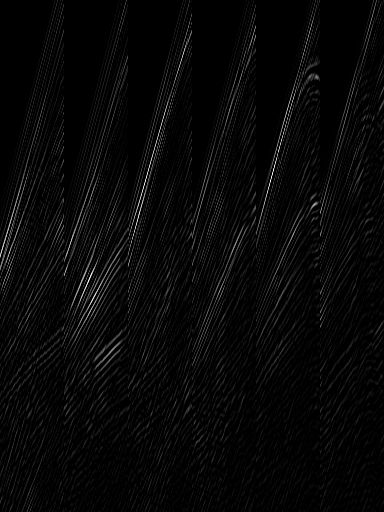

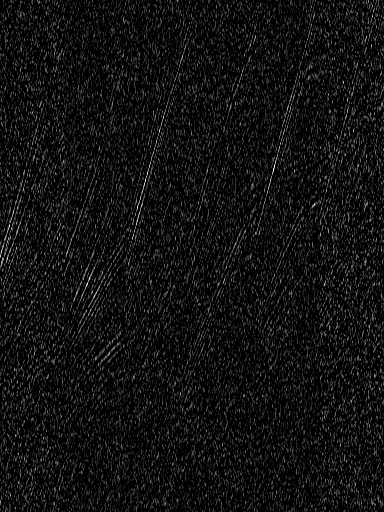

In [992]:
trainA,i = plotseismic(inputdata, 6)
trainB,_= plotseismic(noise, 6,i)
showXY(trainA)
showXY(trainB)
del trainA, trainB,i

In [991]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle
import scipy.io as sio
inputnoise=sio.loadmat('trainnoise1.2.mat')
noise=inputnoise['trainnoise']
noise=noise.reshape(216,512,64,1)
print(noise.shape)
inputdata=sio.loadmat('traindata.mat')
inputdata=inputdata['traindata']
inputdata=inputdata.reshape(216,512,64,1)
print(inputdata.shape)

(216, 512, 64, 1)
(216, 512, 64, 1)


In [990]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle
import scipy.io as sio
valnoise=sio.loadmat('valnoise1.2.mat')
valnoise=valnoise['valnoise']
valnoise=valnoise.reshape(24,512,64,1)
print(valnoise.shape)
valtempdata=sio.loadmat('valdata.mat')
valdata=valtempdata['valdata']
valdata=valdata.reshape(24,512,64,1)
print(valdata.shape)

(24, 512, 64, 1)
(24, 512, 64, 1)


In [866]:
def netG_gen(A):
    return np.concatenate([netG_generate([A[i:i+1]])[0] for i in range(A.shape[0])], axis=0)

[3/10][800] Loss_D: 0.000459 Loss_G: 43.424964 loss_L1: 0.465505 70.93064737319946


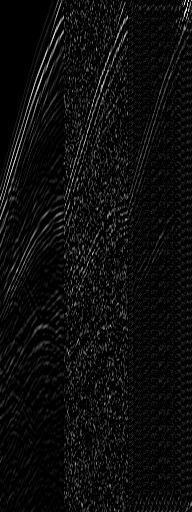

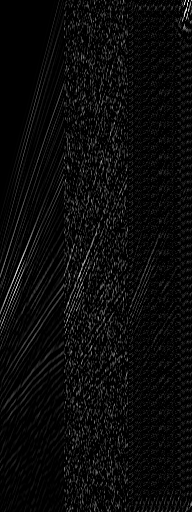

[4/10][1000] Loss_D: 0.000536 Loss_G: 54.426187 loss_L1: 0.552920 88.66730833053589


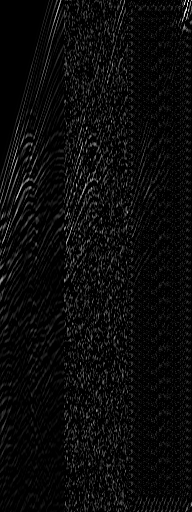

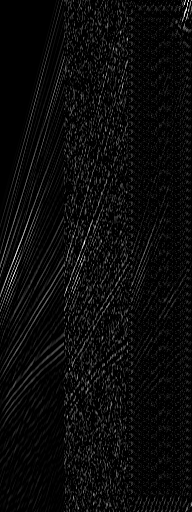

KeyboardInterrupt: 

In [1006]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 10
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

display_iters = 200
# val_batch = minibatch(valAB, 6, direction)
traininput_batch = minibatchseismic(inputdata, batchSize, 0)
trainnoise_batch = minibatchseismic(noise, batchSize, 0)
valinput_batch = minibatchseismic(valdata, batchSize, 0)
valnoise_batch = minibatchseismic(valnoise, batchSize, 0)
while epoch < niter: 
#     epoch, trainA, trainB = next(train_batch) 
    epoch, trainA = next(trainnoise_batch)
    epoch, trainB = next(traininput_batch)
    errD,  = netD_train([trainA, trainB])
    errD_sum +=errD

    errG, errL1 = netG_train([trainA, trainB])
    errG_sum += errG
    errL1_sum += errL1
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        if gen_iterations%(2*display_iters)==0:
            clear_output()
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'
        % (epoch, niter, gen_iterations, errD_sum/display_iters, errG_sum/display_iters, errL1_sum/display_iters), time.time()-t0)
        _, trainA = trainnoise_batch.send(1)
        _, trainB = traininput_batch.send(1)
        fakeB = netG_gen(trainA)
        showXY(np.concatenate([trainB, trainA, fakeB], axis=0), 1)
        _, valA = next(valnoise_batch)
        _, valB = next(valinput_batch)
        valfake = netG_gen(valA)
        showXY(np.concatenate([valB, valA, valfake], axis=0), 1)
        

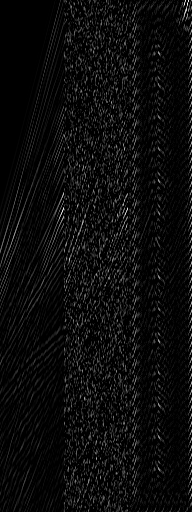

In [1005]:
_, valA = next(valnoise_batch)
_, valB = next(valinput_batch)
valfake = netG_gen(valA)
showXY(np.concatenate([valB, valA, valfake], axis=0), 1)

In [878]:
sio.savemat('valfake.mat', {'valfake': valfake})
sio.savemat('valB.mat', {'valB': valB})
sio.savemat('valA.mat', {'valA': valA})

In [787]:
from skimage import img_as_ubyte
# def floatt2showX(X):
#     a=X.reshape(1,256,64)
#     b=a/np.max(abs(a))
#     b=img_as_ubyte(b)
#     return b
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from IPython.display import display
def showXY(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X=img_as_ubyte(X)
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize1,imageSize2), 1, 1)
    else:
        int_X = int_X.reshape(-1,imageSize1,imageSize2, 1)
    int_X = int_X.reshape(rows, -1, imageSize1, imageSize2,1).swapaxes(1,2).reshape(rows*imageSize1,-1)
    display(Image.fromarray(int_X))

In [925]:
_, trainA = traininput_batch.send(1)
_, trainB = trainnoise_batch.send(1)
fakeB = netG_gen(trainA)
showXY(np.concatenate([trainB, trainA, fakeB], axis=0), 1)

StopIteration: 

# def minibatch(dataAB, batchsize, direction=0):
    length = len(dataAB)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(dataAB)
            i = 0
            epoch+=1        
        dataA = []
        dataB = []
        for j in range(i,i+size):
            imgA,imgB = read_image(dataAB[j], direction)
            dataA.append(imgA)
            dataB.append(imgB)
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        i+=size
        tmpsize = yield epoch, dataA, dataB        
        

# from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

# import time
from IPython.display import clear_output
t0 = time.time()
niter = 50
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

display_iters = 500
val_batch = minibatch(valAB, 6, direction)
train_batch = minibatch(trainAB, batchSize, direction)

while epoch < niter: 
    epoch, trainA, trainB = next(train_batch)        
    errD,  = netD_train([trainA, trainB])
    errD_sum +=errD

    errG, errL1 = netG_train([trainA, trainB])
    errG_sum += errG
    errL1_sum += errL1
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        if gen_iterations%(5*display_iters)==0:
            clear_output()
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'
        % (epoch, niter, gen_iterations, errD_sum/display_iters, errG_sum/display_iters, errL1_sum/display_iters), time.time()-t0)
        _, valA, valB = train_batch.send(6) 
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        errL1_sum = errG_sum = errD_sum = 0
        _, valA, valB = next(val_batch)
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        

In [ ]:
_, valA, valB = train_batch.send(6) 
fakeB = netG_gen(valA)
showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
errL1_sum = errG_sum = errD_sum = 0
_, valA, valB = next(val_batch)
fakeB = netG_gen(valA)
showX(np.concatenate([valA, valB, fakeB], axis=0), 3)